## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_04-10-08-23.csv', firstRow=732, lastRow=738)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_070823_S733-738.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=472s; mass=44.74020000000001g
This equals a volume of 44.83m; expected was 44.988mL; error is 0.351%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0019999999999999996 g/s and for 2nd derivative = 0.0004375 g/s^2


<IPython.core.display.Javascript object>


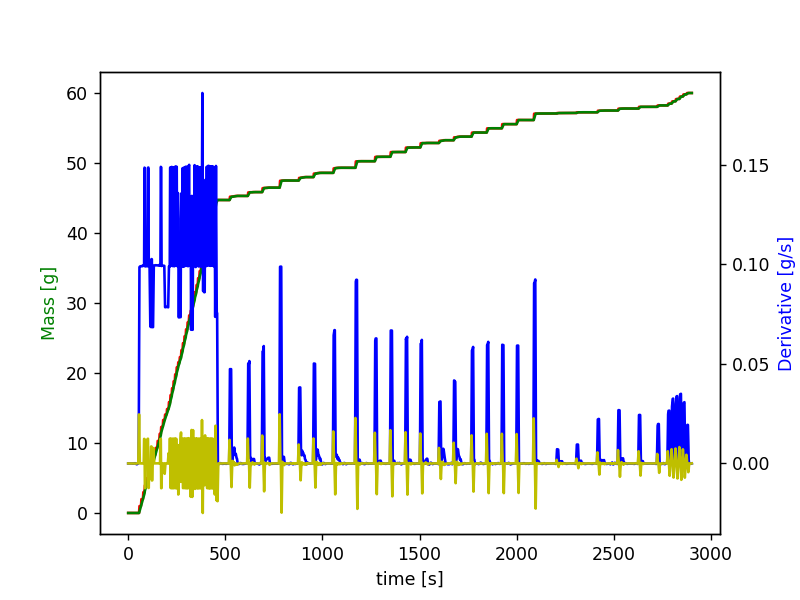

Addition of 0.589g Texapon SB 3 KC detected from 518s to 566s - expected volume = 0.741mL and actual volume = 0.531mL (resulting error is 28.258%)
Addition of 0.551g Plantapon ACG 50 detected from 612s to 654s - expected volume = 0.533mL and actual volume = 0.49mL (resulting error is 8.123%)
Addition of 0.642g Plantapon ACG 50 detected from 686s to 732s - expected volume = 0.533mL and actual volume = 0.571mL (resulting error is 7.023%)
Addition of 1.022g Plantapon ACG 50 detected from 776s to 808s - expected volume = 0.929mL and actual volume = 0.907mL (resulting error is 2.426%)
Addition of 0.493g Plantapon LC 7 detected from 874s to 920s - expected volume = 0.605mL and actual volume = 0.468mL (resulting error is 22.727%)
Addition of 0.608g Plantapon LC 7 detected from 950s to 996s - expected volume = 0.605mL and actual volume = 0.576mL (resulting error is 4.781%)
Addition of 0.726g Plantacare 2000 detected from 1052s to 1086s - expected volume = 0.801mL and actual volume = 0.668mL (r

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

<IPython.core.display.Javascript object>


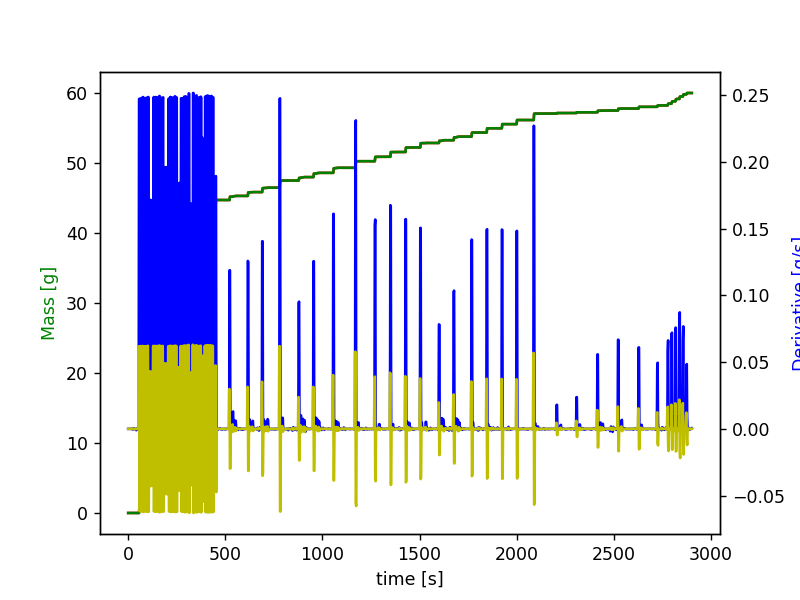

Addition of 0.075g Salcare Super 7 detected from 2152s to 2256s - expected volume = 0.105mL and actual volume = 0.068mL (resulting error is 34.783%)
Addition of 0.102g Salcare Super 7 detected from 2256s to 2366s - expected volume = 0.095mL and actual volume = 0.092mL (resulting error is 2.857%)
Addition of 0.249g Salcare Super 7 detected from 2366s to 2482s - expected volume = 0.24mL and actual volume = 0.226mL (resulting error is 5.682%)
Addition of 0.288g Salcare Super 7 detected from 2482s to 2582s - expected volume = 0.259mL and actual volume = 0.261mL (resulting error is 0.699%)
Addition of 0.248g Salcare Super 7 detected from 2582s to 2680s - expected volume = 0.207mL and actual volume = 0.225mL (resulting error is 8.772%)
Addition of 0.195g Salcare Super 7 detected from 2680s to 2758s - expected volume = 0.155mL and actual volume = 0.177mL (resulting error is 14.035%)


In [22]:
# default bl_mult = 5, default mergeSens = 5
#t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2152,2256,2366,2482,2582,2680,2758])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


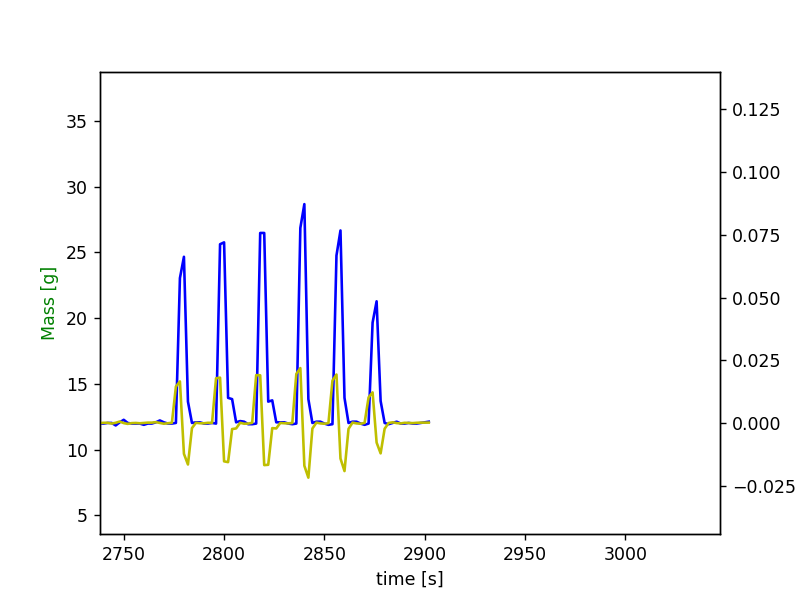

Addition of 0.265g Arlypon TT detected from 2774s to 2788s - expected volume = 0.301mL and actual volume = 0.279mL (resulting error is 7.343%)
Addition of 0.328g Arlypon TT detected from 2794s to 2810s - expected volume = 0.322mL and actual volume = 0.343mL (resulting error is 6.331%)
Addition of 0.337g Arlypon TT detected from 2814s to 2830s - expected volume = 0.318mL and actual volume = 0.354mL (resulting error is 11.221%)
Addition of 0.349g Arlypon TT detected from 2834s to 2848s - expected volume = 0.323mL and actual volume = 0.365mL (resulting error is 12.945%)
Addition of 0.306g Arlypon TT detected from 2852s to 2866s - expected volume = 0.27mL and actual volume = 0.321mL (resulting error is 19.066%)
Addition of 0.191g Arlypon TT detected from 2870s to 2884s - expected volume = 0.16mL and actual volume = 0.2mL (resulting error is 24.837%)


In [23]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2490,2506,2522,2538,2554,2568,2588])

## Consolidate results and create output

In [24]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_070823_S733-S738.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_24080\3762189481.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
732,733.0,0.000000,11.780874,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,11.827310,0.0,0.0,0.0,0.0,0.0,0.740998,0.0,2.618192
733,734.0,0.000000,0.000000,11.181822,0.0,7.37665,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.036389,0.0,3.327621
734,735.0,5.919877,0.000000,0.000000,0.0,0.00000,0.000000,13.082024,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.502631,0.0,3.387094
735,736.0,0.000000,0.000000,0.000000,0.0,0.00000,9.280146,0.000000,0.000000,0.0,11.709721,0.0,0.0,0.0,0.0,0.0,2.842069,0.0,3.444036
736,737.0,0.000000,9.974670,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,9.024655,0.0,0.0,0.0,0.0,0.0,2.421416,0.0,2.987714
737,738.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,12.827660,9.042546,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.928154,0.0,1.888602
